# Workflow Summary
* Set up environment
* Load data
* Choose initial parameters
* Choose parameter bounds
* Define an objective function
    * artificial bounds
    * run forward model
    * apply sensor filter to modeled spectra
    * calculate closure/error
* Build objective function closure, binding specific values
* Minimisation step
* Run forward model on retrieved parameters
* Plot results

# Set up the environment:

In [2]:
%matplotlib inline
import numpy as np
from scipy.optimize import minimize, basinhopping
import sambuca_core as sbc
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from scipy.io import loadmat
import spectral as sp
import spectral.io.envi as envi

# set some controls on numpy formatting
# 5 decimal places, suppress scientific notation
np.set_printoptions(precision=5, suppress=True)

# set the matplotlib style to emulate ggplot2 from R
plt.style.use('ggplot')
plot_width = 9
plot_height = plot_width * 3/4

# spectra to plot
plot_items = list()

## imports for the GUI widgets

In [3]:
from IPython.display import clear_output, display
from IPython.html import widgets

/usr/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Utility Functions

In [4]:
def print_spectral_library(lib):
    #print(dir(lib))
    print("Named Bands:")
    for band_name in lib.names:
        print("\t" + band_name)
    print("Data dimensions: " + str(lib.spectra.shape))
    #print("Available Metadata:")
    #for key in lib.metadata:
    #    print("\t" + key)
        
        
def plot_spectra(plot_items, band_centers):
    plt.figure(figsize=(plot_width, plot_height))
    for pi in plot_items:
        plt.plot(band_centers, pi[0], label=pi[1])

    # set the X axis range
    plt.xlim(np.min(band_centers), np.max(band_centers))
            
    plt.legend(loc='upper right')
    plt.show()
    
    
def print_parameters(p):
    print('CHL:  {0:10.5f}\nCDOM: {1:10.5f}\nTR:   {2:10.5f}\nH:    {3:10.5f}\nQ:    {4:10.5f}'
          .format(p[0],p[1],p[2],p[4],p[3]))
    

def evaluate_forward_model(p, siops, sensor_filter):
    results = sbc.forward_model(
        chl = p[0],
        cdom = p[1],
        nap = p[2],
        depth = p[4],
        substrate_fraction = p[3],
        substrate1=siops['substrate1'],
        substrate2=siops['substrate2'],
        wavelengths=siops['wav'],
        a_water=siops['awater'],
        a_ph_star=siops['aphy_star'],
        num_bands=siops['d_wls'])
        
    if sensor_filter is not None:
        # Apply the sensor filter and return the results
        return sbc.apply_sensor_filter(results.rrs, sensor_filter)
    else:
        return results.rrs
    
def sp_imshow(img, bands=None):
    '''wrap spectral.imshow in a function that traps all errors. I am too lazy to 
    support pass-through of all arguments, so only adding those I am using
    '''
    try:
        sp.imshow(img, bands=(2,1,0))
    except:
        pass

# Load Data
## Load the sambuca model inputs (SIOPS)

In [5]:
filename = '../QBdata/forwardModelTestValues.mat'
siops_data = loadmat(filename, squeeze_me=True)
print(siops_data.keys())

filename = resource_filename(
            sb.__name__,
            'tests/data/test_resample.mat')
sensor_data = loadmat(filename, squeeze_me=True)
print()
print(sensor_data.keys())

print()
print(sensor_data['filt'].shape)

dict_keys(['UQSubs', 'modelled_spectra', 'aphy_star', 'tr', '__version__', 'cdom', '__globals__', 'substrate2', 'wav', '__header__', 'substrate1', 'awater', 'n_wls', 'chl', 'h', 'd_wls', 'q'])


FileNotFoundError: [Errno 2] No such file or directory: '/home/dc/code/sambuca-project/sambuca/sambuca/tests/data/test_resample.mat'

## Load the data:

Named Bands:
	33
Data dimensions: (1, 4)


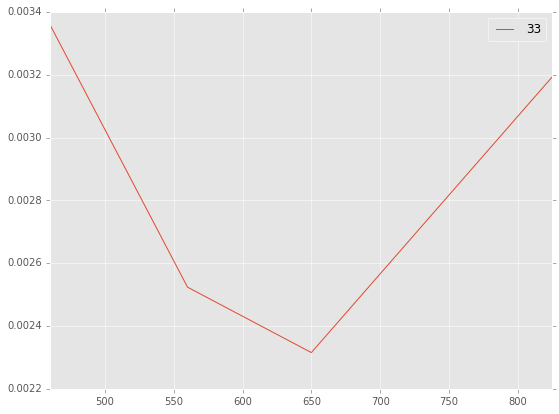

In [6]:
# load what I think is the noise
noise = envi.open(
    '../wl_alos_data/inputs/WL_ALOS_NEDR_0_4bands.hdr',
    '../wl_alos_data/inputs/WL_ALOS_NEDR_0_4bands.lib')
print_spectral_library(noise)

plot_items.clear()
plot_items.append((noise.spectra[0], noise.names[0]))
plot_spectra(plot_items, noise.bands.centers)

Grab the spectral data as a numpy array, and plot it to make sure it looks OK:

	Data Source:   './../wl_alos_data/inputs/WL_ALOS_R_0_sub120.img'
	# Rows:            120
	# Samples:         120
	# Bands:             4
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32




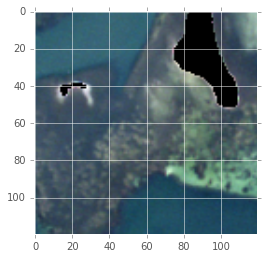

In [7]:
# load the sub120 stuff
sub120 = envi.open(
    '../wl_alos_data/inputs/WL_ALOS_R_0_sub120.hdr',
    '../wl_alos_data/inputs/WL_ALOS_R_0_sub120.img')
print(sub120)
print('\n')
sp_imshow(sub120)

Load the Quickbird sensor filter:

In [8]:
qbfilter = envi.open('../QBdata/QBFilter350_900nm.hdr','../QBdata/QBFilter350_900nm.lib')
print_spectral_library(qbfilter)

Named Bands:
	quickbird - band 1
	quickbird - band 2
	quickbird - band 3
	quickbird - band 4
Data dimensions: (4, 551)


Do a quick plot of the sensor filter, just to make sure it looks OK

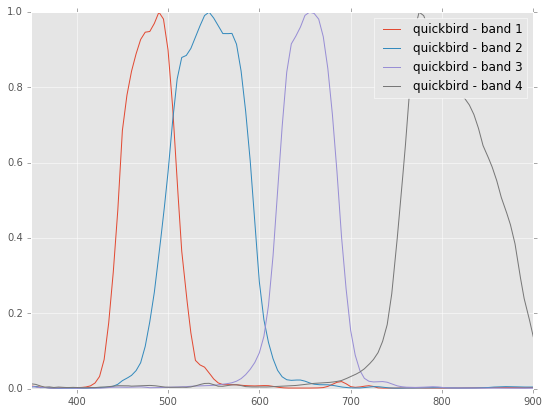

In [9]:
plot_items.clear()
i = 0
for band in qbfilter.names:
    plot_items.append((qbfilter.spectra[i], band))
    i = i + 1
    
plot_spectra(plot_items,qbfilter.bands.centers)

# Initial Parameters and Bounds

## Load the parameter ranges from our test data

In [ ]:
filename = resource_filename(
            sb.__name__,
            'tests/data/test_optimise_data.mat')
data = loadmat(filename, squeeze_me=True)

p_min = data['p_min']
p_max = data['p_max']

#p_min and p_max have already been defined in previous cells (read from test data)
# random parameters often lead to a tougher optimisation challenge
p0_rand = np.random.random(5) * (p_max - p_min) + p_min

# Parameters known to lead Nelder-Mead astray:
p0_bad = np.array([0.13959, 0.00361,  0.73770,  0.07821,  0.02446])

# Semi-reasonable first guess:
p0_ok = np.array([0.093, 0.013,  1.088,  0.815, 7.282])

# repackage p_min and p_max into the tuple of (min,max) pairs expected by our objective function,
# and by the minimisation methods that support bounds
p_bounds = tuple(zip(p_min, p_max))
print('\nBounds = {}'.format(p_bounds))

# Objective Function
Define an objective builder that assembles sambuca components (forward model, sensor filter, error function), using a closure to bind the other inputs.

**TODO** Decide whether it is more efficient to create a new objective function for each pixel, or to use an objective class with a __call__ method. The class object can be called just like the objective function, but it only needs to be created once and can have properties to indicate the current pixel.

## Note to self/design idea
A high level Sambuca class could work as follows:
* constructor arguments
    * observed spectra
    * Sensor filter
    * optional pixel range to calculate. default is all pixels
    * the error function
    * a way to specify the outputs
        * what about a writer pattern? When creating a Sambuca object, you simply pass in a PixelWriter function. It gets called with the final parameters and other data. This can then be used to keep the output handling separate from the parameter estimation code.

In [ ]:
def make_objective(siops, sensor_filter, obs_spectra, p_bounds=None, noise=None):
    awater = siops['awater']
    wav = siops['wav']
    aphy_star = siops['aphy_star']
    substrate1 = siops['substrate1']
    substrate2 = siops['substrate2']
    num_modelled_bands = sensor_filter.shape[1]
    num_observed_bands = sensor_filter.shape[0]
            
    def objective(p):
        # To support algorithms without support for boundary values, we assign a high 
        # score to out of range parameters.
        # p_bounds is a tuple of (min, max) pairs for each parameter in p
        if p_bounds is not None:
            for _p, lu in zip(p, p_bounds):
                l, u = lu
                if _p < l or _p > u:
                    return 100000.0
                    
        # call the forward model
        # We rely on the default values of the other model inputs, which happen to be
        # the same values used in the Matlab code
        spectra = sb.forward_model(
            chl = p[0],
            cdom = p[1],
            nap = p[2],
            depth = p[4],
            substrate_fraction = p[3],
            substrate1=substrate1,
            substrate2=substrate2,
            wav=wav,
            awater=awater,
            aphy_star=aphy_star,
            num_bands=num_modelled_bands)
        
        # Apply the sensor filter
        filtered_spectra = sb.apply_sensor_filter(spectra.rrs, sensor_filter)
        
        # Calculate the error and return it as the objective score
        error = sb.error_all(obs_spectra, filtered_spectra, noise)
        
         #return error.alpha
        #return error.alpha_f
        return error.f
        #return error.lsq
    
    return objective

# Iterate the pixels and run Sambuca on each one

## algorithm
* Create data structures to hold all the outputs
* for each pixel:
    * get an objective function that passes the current pixel values as the observed spectra
    * run the minimiser
    * save the required outputs
* plot or save the outputs

## Test on single pixel

In [ ]:
# get the data ready
x = 2
y = 3
obs_spectra = sub120.read_pixel(x, y)
sensor_filter = qbfilter.spectra
noise_spectra = noise.spectra
p0 = p0_ok

objective = make_objective(
        siops_data, 
        sensor_filter,
        obs_spectra,
        p_bounds=None,
        noise=noise_spectra)

result = minimize(
            objective, 
            p0, 
            method='SLSQP', 
            bounds=p_bounds, 
            options={'disp':True, 'maxiter':500})

p = result['x']
print_parameters(p)
closed_spectra = evaluate_forward_model(p, siops_data, sensor_filter)

plot_items.clear()
plot_items.append((closed_spectra, 'Closed Spectra'))
plot_items.append((obs_spectra, 'Observed Spectra'))
plot_spectra(plot_items, sub120.bands.centers)

## First-pass loop with single substrate pair

**TODO** Profile different iteration methods. Compare objective creation vs a class with updating pixel indicies

### Define the pixel ranges to operate on, and estimate the computation time

In [ ]:
xstart = 70
xend = 95
#xend = xstart + 30
xspan = xend - xstart
ystart = 80
yend = 90
#yend = ystart + 10
npx = xspan * (yend - ystart)

In [ ]:
t = %timeit -o minimize(objective, p0, method='SLSQP', bounds=p_bounds, options={'disp':False, 'maxiter':500})
raster_pixels = sub120.nrows * sub120.ncols
print('Estimated time for {0} pixels: {1} m'.format(npx, npx * t.best / 60))
print('Estimated time for raster, {0} pixels: {1} m'.format(raster_pixels, raster_pixels * t.best / 60))

Start the run:

In [ ]:
# get the data ready
sensor_filter = qbfilter.spectra
noise_spectra = noise.spectra
p0 = p0_ok

# create a hyperspectral file to capture the closed spectra 
md = {'lines':120,
      'samples':120,
      'interleave': 'bip',
      'bands':4}

closed_spectra = envi.create_image('../wl_alos_data/outputs/closed.hdr', md, dtype=np.float32, force=True)
csmm = closed_spectra.open_memmap(interleave='bip', writable=True)

def pixel_result_handler(x, y, params, obs_spectra):
    # save the closed spectra
    csmm[x,y] = evaluate_forward_model(params, siops_data, sensor_filter)

# create a progress bar widget
pb = widgets.IntProgress()
text_widget = widgets.Text()
skip_count_widget = widgets.Text()
pb.max = npx
display(text_widget)
display(skip_count_widget)
display(pb)
n = 0
skip_count = 0

for x in range(xstart, xend):
    for y in range(ystart, yend):
        # reader/player pattern?
        obs_spectra = sub120.read_pixel(x, y)
        
        if not np.allclose(obs_spectra, 0):
            # This would be better if I had separate error functions,
            # as it would allow better parameterisation of the objective creation
            objective = make_objective(
                    siops_data, 
                    sensor_filter,
                    obs_spectra,
                    p_bounds=None,
                    noise=noise_spectra)

            result = minimize(
                        objective, 
                        p0, 
                        method='SLSQP', 
                        bounds=p_bounds, 
                        options={'disp':False, 'maxiter':500})

            # writer/recorder pattern
            pixel_result_handler(x, y, result['x'], obs_spectra)
        else:
            skip_count += 1
            skip_count_widget.value = 'Pixels skipped (bad input spectra): {0}'.format(skip_count)
        
        # update the progress bar
        text_widget.value = 'x: {0}  y: {1}  n: {2}'.format(x, y, n)
        pb.value = n
        n += 1

Have a look at the closed spectra results:

In [ ]:
sp_imshow(sub120)
sp_imshow(csmm)